## Preprocess and Explore Data

In [18]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the tickers and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

# Function to download data with retries
def download_data(ticker, start, end, retries=3):
    for attempt in range(retries):
        try:
            print(f"Downloading data for {ticker} (Attempt {attempt + 1})...")
            data = yf.download(ticker, start=start, end=end)
            if not data.empty:
                data['Ticker'] = ticker
                return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    print(f"Failed to download data for {ticker} after {retries} attempts.")
    return pd.DataFrame()

# Download data for each ticker
all_data = []
for ticker in tickers:
    data = download_data(ticker, start_date, end_date)
    if not data.empty:
        all_data.append(data)

# Combine all data
if all_data:
    df = pd.concat(all_data)
    df.reset_index(inplace=True)
    print("Data successfully downloaded and combined.")
else:
    raise ValueError("Failed to download any data.")

# Save the initial dataset
df.to_csv('complete_historical_data.csv', index=False)
print("Initial data saved to 'complete_historical_data_new.csv'")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data successfully downloaded and combined.


Initial data saved to 'complete_historical_data_new.csv'


In [2]:
tickers = ['TSLA', 'BND', 'SPY']

In [3]:
# Define the date range
start_date = '2015-01-01'
end_date = '2024-10-31'

In [ ]:
# Fetch the data for each ticker
data = {}
for ticker in tickers:
    asset_data = yf.download(ticker, start=start_date, end=end_date)
    asset_data['Ticker'] = ticker  
    data[ticker] = asset_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# Combine the data into a single DataFrame
combined_data = pd.concat(data.values())

# Reset the index for easier analysis
combined_data.reset_index(inplace=True)

In [10]:
combined_data.head(10)

Price,Date,Adj Close,Close,High,Low,Open,Volume,Ticker,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,BND,BND,BND,BND,BND,BND,SPY,SPY,SPY,SPY,SPY,SPY
0,2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-01-09 00:00:00+00:00,13.777333,13.777333,13.998667,13.664000,13.928000,70024500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-12 00:00:00+00:00,13.480667,13.480667,13.631333,13.283333,13.536667,89254500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-01-13 00:00:00+00:00,13.616667,13.616667,13.840667,13.394000,13.554667,67159500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-01-14 00:00:00+00:00,12.846000,12.846000,13.013333,12.333333,12.388667,173278500.0,TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Display the first few rows of the combined dataset
print(combined_data.head())

Price                       Date  Adj Close      Close       High        Low  \
Ticker                                 TSLA       TSLA       TSLA       TSLA   
0      2015-01-02 00:00:00+00:00  14.620667  14.620667  14.883333  14.217333   
1      2015-01-05 00:00:00+00:00  14.006000  14.006000  14.433333  13.810667   
2      2015-01-06 00:00:00+00:00  14.085333  14.085333  14.280000  13.614000   
3      2015-01-07 00:00:00+00:00  14.063333  14.063333  14.318667  13.985333   
4      2015-01-08 00:00:00+00:00  14.041333  14.041333  14.253333  14.000667   

Price        Open      Volume Ticker Adj Close Close High Low Open Volume  \
Ticker       TSLA        TSLA              BND   BND  BND BND  BND    BND   
0       14.858000  71466000.0   TSLA       NaN   NaN  NaN NaN  NaN    NaN   
1       14.303333  80527500.0   TSLA       NaN   NaN  NaN NaN  NaN    NaN   
2       14.004000  93928500.0   TSLA       NaN   NaN  NaN NaN  NaN    NaN   
3       14.223333  44526000.0   TSLA       NaN   NaN  

In [8]:
# Save the data to CSV files (optional)
combined_data.to_csv('historical_financial_data.csv', index=False)

In [11]:
import yfinance as yf
import pandas as pd

# Define the ticker symbols and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

# Create an empty list to store DataFrames
dfs = []

# Loop through each ticker and download the data
for ticker in tickers:
    # Fetch historical data
    df = yf.download(ticker, start=start_date, end=end_date)
    # Rename columns to include the ticker symbol (e.g., 'TSLA_Open', 'TSLA_Close')
    df.columns = [f"{ticker}_{col}" for col in df.columns]
    # Add the 'Date' column to the DataFrame
    df['Date'] = df.index
    # Reset index and append to the list
    dfs.append(df.reset_index(drop=True))

# Merge the data on the 'Date' column
merged_data = pd.merge(dfs[0], dfs[1], on='Date', how='outer')
merged_data = pd.merge(merged_data, dfs[2], on='Date', how='outer')

# Display the first few rows of the merged dataset
print(merged_data.head())

# Save the merged data to a CSV file
merged_data.to_csv('merged_financial_data.csv', index=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


   TSLA_('Adj Close', 'TSLA')  TSLA_('Close', 'TSLA')  TSLA_('High', 'TSLA')  \
0                   14.620667               14.620667              14.883333   
1                   14.006000               14.006000              14.433333   
2                   14.085333               14.085333              14.280000   
3                   14.063333               14.063333              14.318667   
4                   14.041333               14.041333              14.253333   

   TSLA_('Low', 'TSLA')  TSLA_('Open', 'TSLA')  TSLA_('Volume', 'TSLA')  \
0             14.217333              14.858000                 71466000   
1             13.810667              14.303333                 80527500   
2             13.614000              14.004000                 93928500   
3             13.985333              14.223333                 44526000   
4             14.000667              14.187333                 51637500   

                       Date  BND_('Adj Close', 'BND')  BND_('Close',

In [17]:
print("Missing Values:\n", merged_data.isnull().sum())

Missing Values:
 TSLA_('Adj Close', 'TSLA')    0
TSLA_('Close', 'TSLA')        0
TSLA_('High', 'TSLA')         0
TSLA_('Low', 'TSLA')          0
TSLA_('Open', 'TSLA')         0
TSLA_('Volume', 'TSLA')       0
Date                          0
BND_('Adj Close', 'BND')      0
BND_('Close', 'BND')          0
BND_('High', 'BND')           0
BND_('Low', 'BND')            0
BND_('Open', 'BND')           0
BND_('Volume', 'BND')         0
SPY_('Adj Close', 'SPY')      0
SPY_('Close', 'SPY')          0
SPY_('High', 'SPY')           0
SPY_('Low', 'SPY')            0
SPY_('Open', 'SPY')           0
SPY_('Volume', 'SPY')         0
dtype: int64


In [ ]:
merged_data.head()

,"TSLA_('Adj Close', 'TSLA')","TSLA_('Close', 'TSLA')","TSLA_('High', 'TSLA')","TSLA_('Low', 'TSLA')","TSLA_('Open', 'TSLA')","TSLA_('Volume', 'TSLA')",Date,"BND_('Adj Close', 'BND')","BND_('Close', 'BND')","BND_('High', 'BND')","BND_('Low', 'BND')","BND_('Open', 'BND')","BND_('Volume', 'BND')","SPY_('Adj Close', 'SPY')","SPY_('Close', 'SPY')","SPY_('High', 'SPY')","SPY_('Low', 'SPY')","SPY_('Open', 'SPY')","SPY_('Volume', 'SPY')"
0,14.620667,14.620667,14.883333,14.217333,14.858000,71466000,2015-01-02 00:00:00+00:00,63.358749,82.650002,82.690002,82.419998,82.430000,2218800,173.173752,205.429993,206.880005,204.179993,206.380005,121465900
1,14.006000,14.006000,14.433333,13.810667,14.303333,80527500,2015-01-05 00:00:00+00:00,63.542709,82.889999,82.919998,82.699997,82.739998,5820100,170.046326,201.720001,204.369995,201.350006,204.169998,169632600
2,14.085333,14.085333,14.280000,13.614000,14.004000,93928500,2015-01-06 00:00:00+00:00,63.726711,83.129997,83.379997,83.029999,83.029999,3887600,168.444656,199.820007,202.720001,198.860001,202.089996,209151400
3,14.063333,14.063333,14.318667,13.985333,14.223333,44526000,2015-01-07 00:00:00+00:00,63.765015,83.180000,83.279999,83.050003,83.139999,2433400,170.543640,202.309998,202.720001,200.880005,201.419998,125346700
4,14.041333,14.041333,14.253333,14.000667,14.187333,51637500,2015-01-08 00:00:00+00:00,63.665394,83.050003,83.110001,82.970001,83.110001,1873400,173.569916,205.899994,206.160004,203.990005,204.009995,147217800


In [19]:
# Check data types
print("Data Types:\n", merged_data.dtypes)

Data Types:
 TSLA_('Adj Close', 'TSLA')                float64
TSLA_('Close', 'TSLA')                    float64
TSLA_('High', 'TSLA')                     float64
TSLA_('Low', 'TSLA')                      float64
TSLA_('Open', 'TSLA')                     float64
TSLA_('Volume', 'TSLA')                     int64
Date                          datetime64[ns, UTC]
BND_('Adj Close', 'BND')                  float64
BND_('Close', 'BND')                      float64
BND_('High', 'BND')                       float64
BND_('Low', 'BND')                        float64
BND_('Open', 'BND')                       float64
BND_('Volume', 'BND')                       int64
SPY_('Adj Close', 'SPY')                  float64
SPY_('Close', 'SPY')                      float64
SPY_('High', 'SPY')                       float64
SPY_('Low', 'SPY')                        float64
SPY_('Open', 'SPY')                       float64
SPY_('Volume', 'SPY')                       int64
dtype: object


## Exploratory Data Analysis

In [24]:
print(merged_data.columns)

Index(['TSLA_('Adj Close', 'TSLA')', 'TSLA_('Close', 'TSLA')',
       'TSLA_('High', 'TSLA')', 'TSLA_('Low', 'TSLA')',
       'TSLA_('Open', 'TSLA')', 'TSLA_('Volume', 'TSLA')', 'Date',
       'BND_('Adj Close', 'BND')', 'BND_('Close', 'BND')',
       'BND_('High', 'BND')', 'BND_('Low', 'BND')', 'BND_('Open', 'BND')',
       'BND_('Volume', 'BND')', 'SPY_('Adj Close', 'SPY')',
       'SPY_('Close', 'SPY')', 'SPY_('High', 'SPY')', 'SPY_('Low', 'SPY')',
       'SPY_('Open', 'SPY')', 'SPY_('Volume', 'SPY')'],
      dtype='object')


In [23]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    subset = merged_data[merged_data['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close'], label=ticker)
plt.title('Closing Prices of TSLA, BND, SPY (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

KeyError: 'Ticker'

<Figure size 1400x700 with 0 Axes>

In [27]:
# Define ticker symbols and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

# Step 1: Data Extraction
def fetch_data(ticker):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Ticker'] = ticker
    return data


In [28]:
# Fetch data for each asset
tsla_data = fetch_data('TSLA')
bnd_data = fetch_data('BND')
spy_data = fetch_data('SPY')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
# Combine the data into a single DataFrame
data = pd.concat([tsla_data, bnd_data, spy_data])
data.reset_index(inplace=True)

In [30]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Price      Ticker
Date                    0
Adj Close  TSLA      4948
Close      TSLA      4948
High       TSLA      4948
Low        TSLA      4948
Open       TSLA      4948
Volume     TSLA      4948
Ticker                  0
Adj Close  BND       4948
Close      BND       4948
High       BND       4948
Low        BND       4948
Open       BND       4948
Volume     BND       4948
Adj Close  SPY       4948
Close      SPY       4948
High       SPY       4948
Low        SPY       4948
Open       SPY       4948
Volume     SPY       4948
dtype: int64


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_19304\3094494038.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_19304\3094494038.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Missing Data Summary After Download:
 Price      Ticker
Date                    0
Adj Close  TSLA      4948
Close      TSLA      4948
High       TSLA      4948
Low        TSLA      4948
Open       TSLA      4948
Volume     TSLA      4948
Ticker                  0
Adj Close  BND       4948
Close      BND       4948
High       BND       4948
Low        BND       4948
Open       BND       4948
Volume     BND       4948
Adj Close  SPY       4948
Close      SPY       4948
High       SPY       4948
Low        SPY       4948
Open       SPY       4948
Volume     SPY       4948
dtype: int64
Missing Data Summary After Handling:
 Price      Ticker
Date                 0
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
Ticker               0
Adj Close  BND       0
Close      BND       0
High       BND       0
Low        BND       0
Open       BND       0
Volume     BND       0
Adj Close  SPY       0
Close     

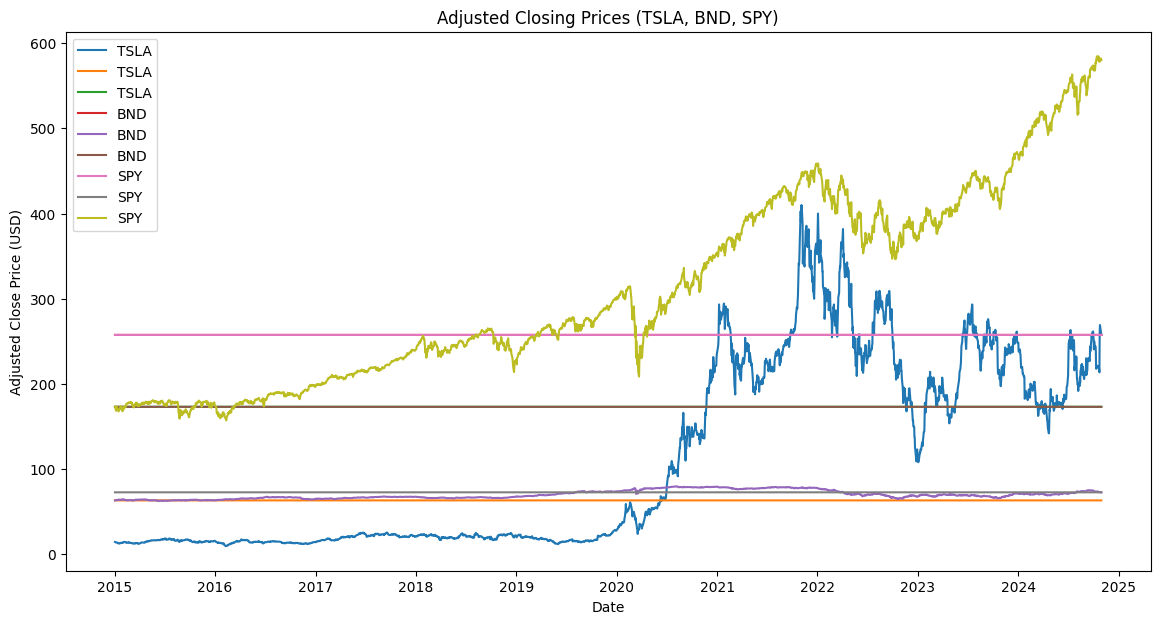

In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define the tickers and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

# Function to download data with retries
def download_data(ticker, start, end, retries=3):
    for attempt in range(retries):
        try:
            print(f"Downloading data for {ticker} (Attempt {attempt + 1})...")
            data = yf.download(ticker, start=start, end=end)
            if not data.empty:
                data['Ticker'] = ticker
                return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    print(f"Failed to download data for {ticker} after {retries} attempts.")
    return pd.DataFrame()

# Step 1: Download data for each ticker and combine
all_data = []
for ticker in tickers:
    data = download_data(ticker, start_date, end_date)
    if not data.empty:
        all_data.append(data)

# Step 2: Concatenate all data and reset index
if all_data:
    df = pd.concat(all_data)
    df.reset_index(inplace=True)
else:
    raise ValueError("Failed to download any data.")

# Step 3: Check for missing data after download
missing_summary = df.isnull().sum()
print("Missing Data Summary After Download:\n", missing_summary)

# Step 4: Handle Missing Values
# Forward-fill and backward-fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Verify if there are still missing values
missing_summary_after = df.isnull().sum()
print("Missing Data Summary After Handling:\n", missing_summary_after)

# Step 5: Save the cleaned data to a CSV file
output_file = 'complete_historical_data.csv'
df.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")

# Step 6: Plot the adjusted closing prices for all tickers
plt.figure(figsize=(14, 7))
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)
plt.title('Adjusted Closing Prices (TSLA, BND, SPY)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()


C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_19304\200903903.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


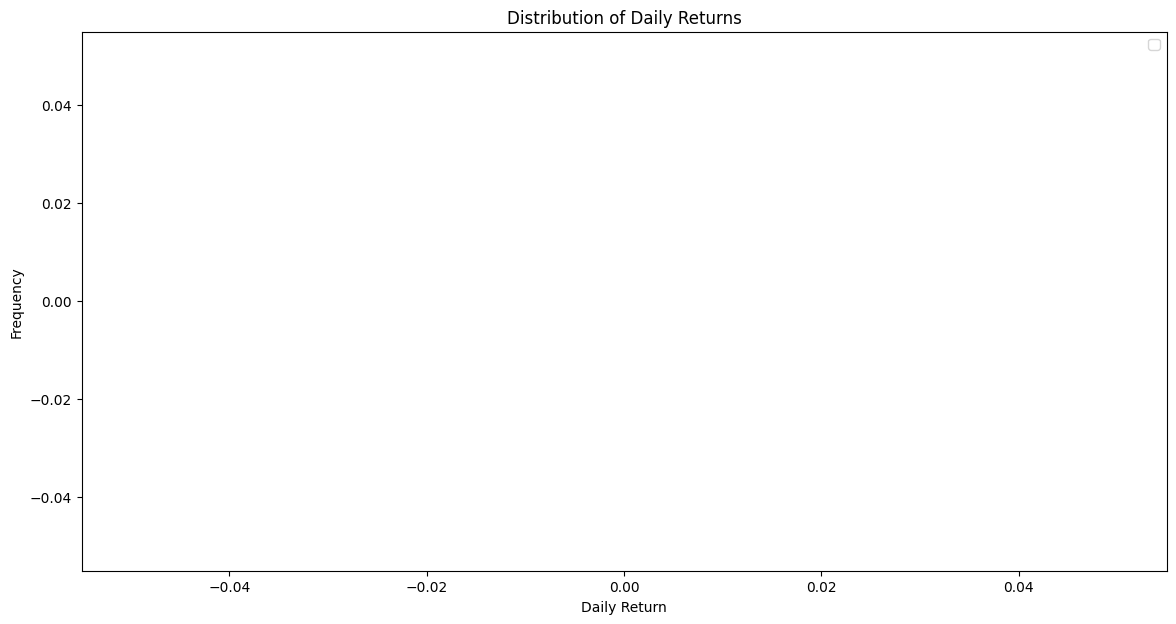

In [37]:
# Step 7: Calculate Daily Percentage Change (Volatility)
for ticker in tickers:
    df.loc[df['Ticker'] == ticker, f'{ticker}_Daily_Return'] = df[df['Ticker'] == ticker]['Adj Close'].pct_change()

# Plot daily percentage change distribution
plt.figure(figsize=(14, 7))
for ticker in tickers:
    sns.histplot(df[f'{ticker}_Daily_Return'].dropna(), bins=100, kde=True, label=ticker)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

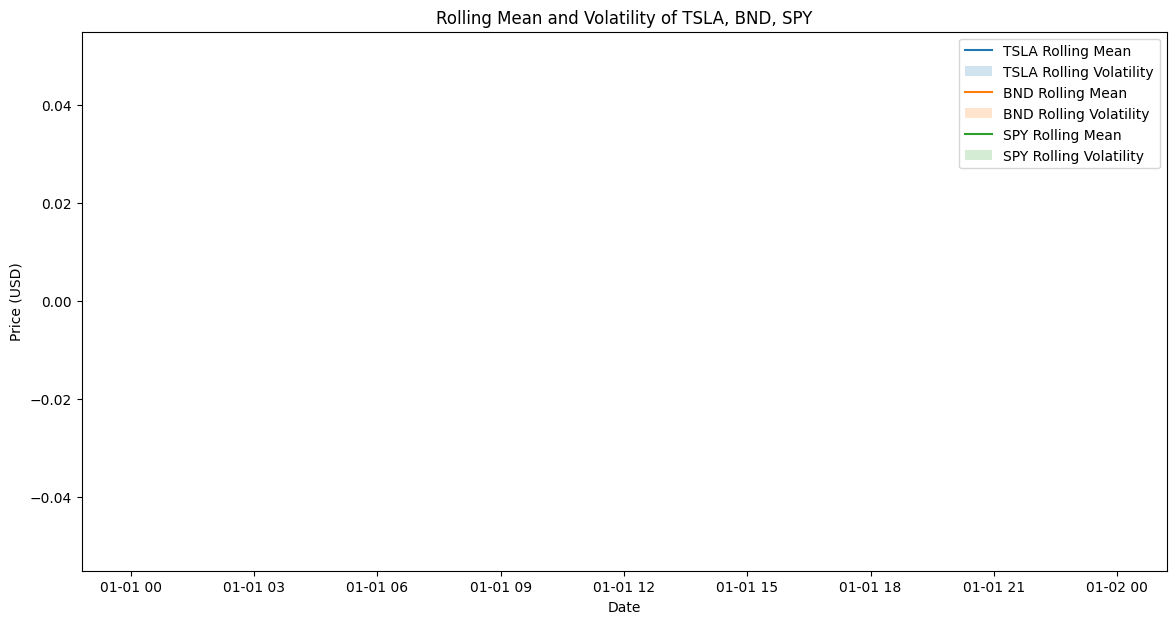

In [39]:
# Step 8: Calculate Rolling Mean and Standard Deviation (30-day window)
window = 30
for ticker in tickers:
    df.loc[df['Ticker'] == ticker, f'{ticker}_Rolling_Mean'] = df[df['Ticker'] == ticker]['Adj Close'].rolling(window).mean()
    df.loc[df['Ticker'] == ticker, f'{ticker}_Rolling_Std'] = df[df['Ticker'] == ticker]['Adj Close'].rolling(window).std()

# Plot rolling mean and standard deviation
plt.figure(figsize=(14, 7))
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset[f'{ticker}_Rolling_Mean'], label=f'{ticker} Rolling Mean')
    plt.fill_between(subset['Date'],
                     subset[f'{ticker}_Rolling_Mean'] - subset[f'{ticker}_Rolling_Std'],
                     subset[f'{ticker}_Rolling_Mean'] + subset[f'{ticker}_Rolling_Std'],
                     alpha=0.2, label=f'{ticker} Rolling Volatility')
plt.title('Rolling Mean and Volatility of TSLA, BND, SPY')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [40]:
# Step 10: Time Series Decomposition for TSLA
tsla_close = df[df['Ticker'] == 'TSLA']['Adj Close'].dropna()
decomposition = seasonal_decompose(tsla_close, model='multiplicative', period=365)
decomposition.plot()
plt.suptitle('Time Series Decomposition of TSLA', fontsize=16)
plt.show()

# Step 11: Volatility Analysis (VaR and Sharpe Ratio)
def calculate_var(returns, confidence_level=0.95):
    return np.percentile(returns.dropna(), 100 * (1 - confidence_level))

def calculate_sharpe_ratio(returns):
    mean_return = returns.mean()
    std_return = returns.std()
    return mean_return / std_return

# Calculate and print VaR and Sharpe Ratio
for ticker in tickers:
    returns = df[f'{ticker}_Daily_Return']
    var = calculate_var(returns)
    sharpe_ratio = calculate_sharpe_ratio(returns)
    print(f"{ticker} - VaR: {var:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")

TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

In [33]:
# Plot daily percentage change
plt.figure(figsize=(14, 7))
for ticker in ['TSLA', 'BND', 'SPY']:
    sns.histplot(data[f'{ticker}_Daily_Return'].dropna(), bins=100, kde=True, label=ticker)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

KeyError: 'TSLA_Daily_Return'

<Figure size 1400x700 with 0 Axes>

In [32]:
tickers = ['TSLA', 'BND', 'SPY']
for ticker in tickers:
    data[f'{ticker}_Daily_Return'] = data[f'{ticker}_Adj Close'].pct_change()

KeyError: 'TSLA_Adj Close'